Compare LDA, QDA, and NB for both schemes (compute accuracy on the testing
set) for fixed value alpha = 2 and different values of rho = 0, 0.1, 0.3, 0.5, 0.7, 0.9.

Repeat the experiment for different train/test splits and generate boxplots showing the values of accuracy for each method and each value of the parameter rho.

Save the results in the file BayesianSimulatedData2.pdf

In [64]:
import matplotlib.pyplot as plt
import numpy as np

from tools import generate_y, generate_data_1, generate_data_2
from tools import train_test_split

from BinaryClassifiers import BinaryClassifier, LDA, QDA, NaiveBayes


In [65]:
np.random.seed(1337)


In [66]:
prob = 0.5
n = 1000

mean = 0
variance = 1


alpha = 2
rho_list = (0, 0.1, 0.3, 0.5, 0.7, 0.9)

models = (LDA, QDA, NaiveBayes)


In [67]:
def experiment_model(
        model: BinaryClassifier,
        prob, n, mean, alpha, variance, rho
        ) -> None:

    results = {  # dataset: model accuracy
        0: [],
        1: []
    }

    for train_size in (0.5, 0.6, 0.7, 0.8, 0.9):
        y = generate_y(prob, n)
        data_2 = generate_data_2(y, rho, alpha)

        train_2, test_2, = train_test_split(data_2, train_size)

        for i, data in enumerate((None, (train_2, test_2))):
            if data is None:
                continue

            train, test = data
            model_instance: BinaryClassifier = model()
            model_instance.fit(train[:, 1:], train[:, 0])

            all_responses = 0
            good_responses = 0
            for record in test:
                y, x1, x2 = record
                y = int(y)

                y_predicted = int(model_instance.predict((x1, x2)))

                if y_predicted == y:
                    good_responses += 1

                all_responses += 1

            results[i].append(good_responses/all_responses*100)

    return results


def draw_model_experiment(model: BinaryClassifier, results: dict) -> None:
    colors = ("#ff7f0e", )
    labels = ("Dataset 1", )

    rhos = sorted(results.keys())
    positions = np.arange(len(rhos))

    plt.figure(figsize=(12, 6))

    for i, (_, results) in enumerate(results.items()):
        set_1_data = results[1]
        box = plt.boxplot(
            [set_1_data],
            positions=[positions[i]],
            widths=0.6,
            patch_artist=True
            )

        for patch, color in zip(box["boxes"], colors):
            patch.set_facecolor(color)

    plt.legend(box["boxes"][:2], labels, loc="upper right")

    plt.xticks(positions + 0.5, [str(rho) for rho in rhos])
    plt.xlabel("Rho")
    plt.ylabel("Accuracy (%)")
    title = f"Comparison of averange {model.name} accuracy "
    title += "for different values of the rho parameter"
    plt.title(title)

    plt.savefig(f"plots/{model.name}_basedon_rho.jpg")
    plt.tight_layout()
    plt.show()


## Important
Since the rho parameter is not used to generate dataset 0, we do not test classifiers on it.


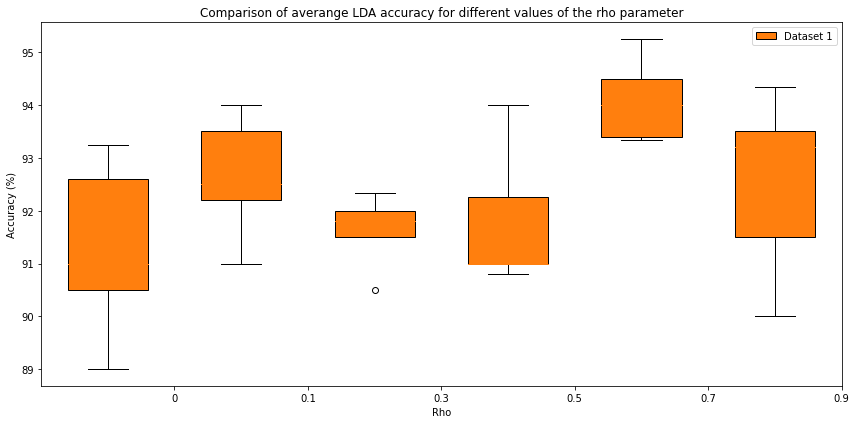

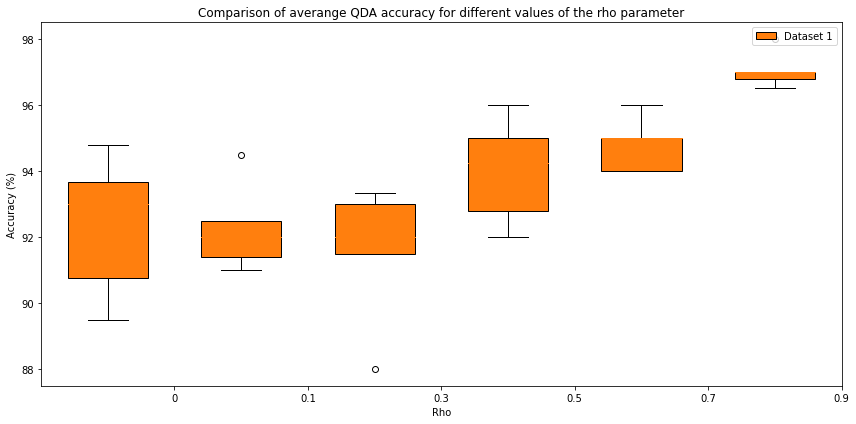

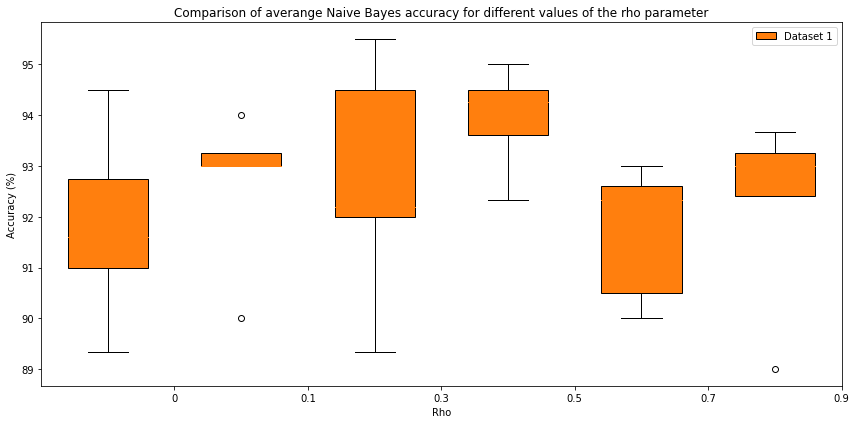

In [68]:
for model in models:
    results = {}
    for rho in rho_list:
        results[rho] = experiment_model(
            model,
            prob, n, mean, alpha, variance, rho
            )
    draw_model_experiment(model, results)


As you can see, changing the value of the rho parameter does not significantly affect LDA and Naive Bayes.
Only QDA has a slight improvement when increasing rho.

Let's see how data set vary depending on the rho value:


In [69]:
def draw(data2: np.array, name: str) -> None:
    plt.figure(figsize=(10, 10))

    y0 = data2[:, 0] == 0
    plt.scatter(
        data2[y0][:, 1],
        data2[y0][:, 2],
        color="green",
        label="Class 0 (Dataset 1)"
    )

    y1 = data2[:, 0] == 1
    plt.scatter(
        data2[y1][:, 1],
        data2[y1][:, 2],
        color="orange",
        label="Class 1 (Dataset 1)"
    )

    plt.legend()
    plt.xlabel("Feature 1 value")
    plt.ylabel("Feature 2 value")
    plt.title("Data distribution for dataset 1")

    plt.suptitle(f"Comparison of data distributions with rho = {rho}")
    plt.savefig(f"plots/{name}.jpg")
    plt.show()


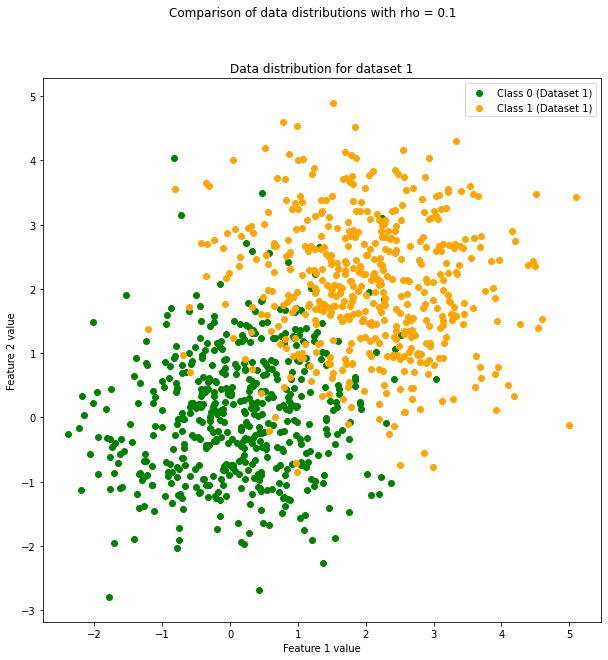

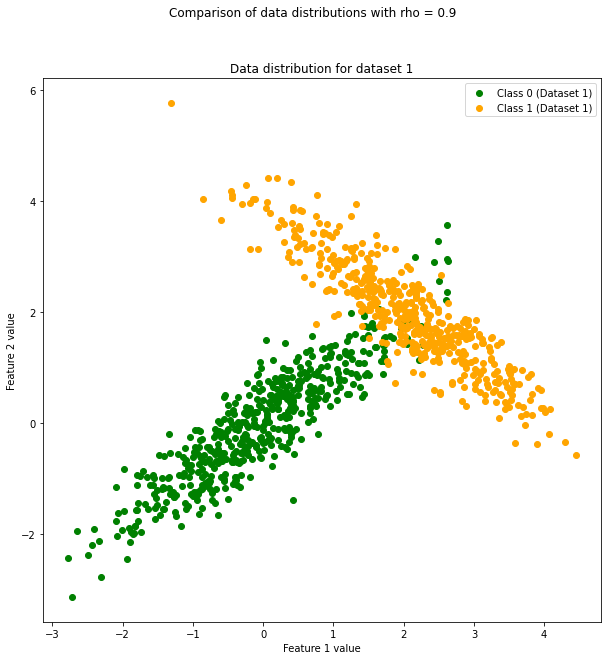

In [70]:
for rho in (0.1, 0.9):
    y = generate_y(prob, n)
    data2 = generate_data_2(y, rho, alpha)

    draw(data2, f"data_distribution_rho_{rho}")


As we can see, increasing the value of the rho parameter flattens the set of points.

LDA and Naive Bayes are linear, so they cannot draw a line on the separation of sets.

Let's see how QDA deals with this:


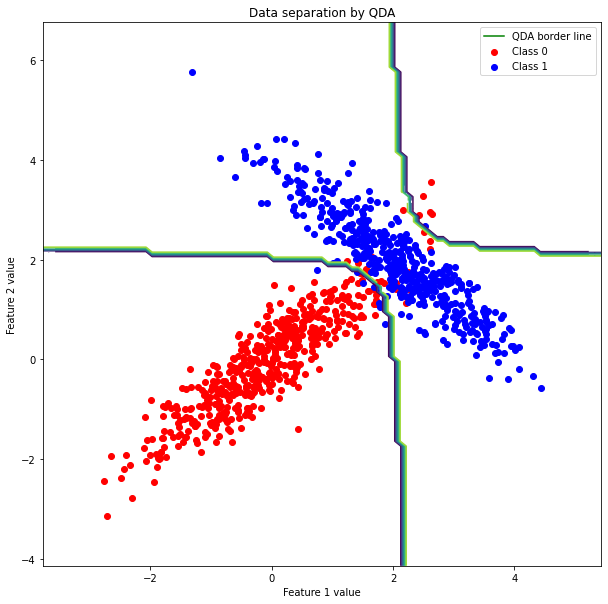

In [71]:
model = QDA()
model.fit(data2[:, 1:], data2[:, 0])

xx, yy, z = model.find_border()

plt.figure(figsize=((10, 10)))

contour = plt.contour(xx, yy, z)
plt.clabel(contour, fontsize=0)
plt.plot([], [], "g", label="QDA border line")

plt.scatter(
    data2[data2[:, 0] == 0][:, 1],
    data2[data2[:, 0] == 0][:, 2],
    color="red",
    label="Class 0"
    )

plt.scatter(
    data2[data2[:, 0] == 1][:, 1],
    data2[data2[:, 0] == 1][:, 2],
    color="blue",
    label="Class 1"
    )

plt.legend()
plt.xlabel("Feature 1 value")
plt.ylabel("Feature 2 value")
plt.title("Data separation by QDA")
plt.savefig("plots/QDA_data_separation_rho.png")
plt.show()
